# Low Ground Flying UAV Dataset

The uav dataset consist of video frames at 10 fps of a low-flying UAV. Although the altitude is not specified, the UAV hovers low enough to capture moving objects. The video frames are partitioned by different instances of the moving objects/people. For example, the first few directories are named as 'bike1', 'bike2', 'bike3' etc. 

Because the dataset consists of purely images, the first step is to save the absolute paths of the images as a pandas dataframe in a pickle file. The dataframe will contain columns containing the path of the image and root directory name (i.e. 'bike1').

The following method save_data_csv constructs a dataframe as described recently, and saves it as pickle file.

In [7]:
# %load core/save_csv.py
import os
import pandas as pd
import pickle

def save_data_csv(prefix, root_dir, file_to_save):
    '''
    Arguements:
        prefix - str list of directory names to save 
        root_dir - str path of uav dataset
        file_to_save - path to save file
        
    '''
    data_frame = []
    if not isinstance(prefix, list):
        prefix = [prefix]
    for sub_dir in os.listdir(root_dir):
        # check if any selected prefixes are in directory str
        if any(pre in sub_dir for pre in prefix):
            class_dir = os.path.join(root_dir, sub_dir)
            img_names = os.listdir(class_dir)
            # append each path
            for images in img_names:
                data_frame.append([os.path.join(class_dir, images), sub_dir])

    pd_data_frame = pd.DataFrame(data_frame, columns=['frame', 'object'])
    
    # Save dataframe
    with open(file_to_save + '.pickle', 'wb') as handle:
        pickle.dump(pd_data_frame, handle)
    
    return pd_data_frame


root_dir = '/Users/jesusnavarro/Desktop/gan_video/data_compressed/data_seq/UAV123_10fps/'
file_to_save = 'data_loader_example'
df = save_data_csv('bike', root_dir, file_to_save)


## Open the file and perform a sanity check

In [16]:
with open(file_to_save + '.pickle', 'rb') as handle:
    df = pickle.load(handle)

print('The bike directory contains {} total images'.format(len(df)))

object_list = []

for obj in df['object'].tolist():
    if obj not in object_list:
        object_list.append(obj)

print('The pickle file contains images form ', object_list)

The bike directory contains 1359 total images
The pickle file contains images form  ['bike3', 'bike2', 'bike1']


# Next Step: Construct DataLoader

Pytorch offers an abstract class called Dataloader which combines its own 'Dataset' class and an iterator which provides a simple and efficient method of pre-processing and sampling data. The 'dataset' class is an abstract class that represents a dataset. To construct a dataloader, I create a custom class that inherits Pytorch's 'Dataset' class and overrides two methods to iterate through the uav dataset.

In [78]:
# %load core/dataset.py
from PIL import Image
from imageio import imread
from torchvision import transforms, utils
import os
import pickle
import numpy as np
from keras.preprocessing import image
from skimage import io, transform
import torch.nn as nn

import torch
import pandas as pd


class UAVDataset(torch.utils.data.Dataset):
    """ UAV Flight DataSet
    Inherits DataSet abstract class from pytroch
    Overrides methods __len__ and __getitem__
    """

    def __init__(self, pickle_path, transform=None):
        """

        :param csv_file_path: path to saved csv file
        :param root_dir: root directory where data is stored
        :param transform: tensor.transforms applied to data
        """
        with open(pickle_path, 'rb') as handle:
            self.flight_frames = pickle.load(handle)
        self.transform = transform

    def __len__(self):
        return len(self.flight_frames)

    def __getitem__(self, item_id):
        video_frames = self.flight_frames.iloc[item_id]['frame']
        object_ = self.flight_frames.iloc[item_id]['object']
        data = {'frame': video_frames, 'class': object_}

        if self.transform:
            data = self.transform(data)
        return data



class Rescale(object):
    """ Transform to rescale image
    """
    def __init__(self, output_size):
        """
        :param output_size: int to resize image (3 x output_size x output_size)
        """
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        """
        returns dictionary with key 'video' and img array and path

        """
        filename = sample['frame']
        img = image.load_img(filename, target_size=(self.output_size, self.output_size))
        return {'frame': img, 'class': sample['class']}


class ToTensor(object):
    """
    Converts data to tensors and applies normalization transform

    Input tensors are of size (N, Channels, Depth, Height, Width)

    TODO: Fix class values. """
    
    def __call__(self, sample):
        img = sample['frame']
        class_ = sample['class']
        trans = transforms.ToTensor()
        video = trans(img)
        #norm_t = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        #video = norm_t(video.float())
        #video = video.unsqueeze(0)
        return {'frame': video, 'class': class_}

class Normalize():

    def __call__(self, sample):
        video = sample['frame'][0]
        filename = sample['frame'][1]
        x = transforms.Normalize(0.5, 0.5)
        video = x(video)
        return {'frame': [video, filename]}


## Dataloader example with rescale and tensor transform

In [96]:
# %load '/Users/jesusnavarro/Desktop/gan_video/core/main.py'
from keras_preprocessing.image import save_img
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.transforms import ToPILImage
import sys
import imageio
from skimage import img_as_ubyte
from PIL import Image
import IPython.display
import numpy as np
import matplotlib.pyplot as plt


def denorm(x):
    out = (x + 1.0) / 2.0
    tf = nn.Tanh()
    return tf(out)

# Define composed transorm
composed = transforms.Compose([Rescale(64), ToTensor()])
file_name = file_to_save + '.pickle'

# Instantiate DataLoader object
transformed_uav_dataset = UAVDataset(pickle_path=file_name,
                                     transform=composed)

# Create dataloader object
data_loader = DataLoader(transformed_uav_dataset,
                         batch_size=10,
                         shuffle=False)

# iterate through the dataset, 

img_list = []
for num, batch in enumerate(data_loader, 0):
    if num % 5 == 0:
        imgs = batch['frame']
        img = imgs[0]
        img_list.append(img.permute(1,2,0))



# Showing a few images

28


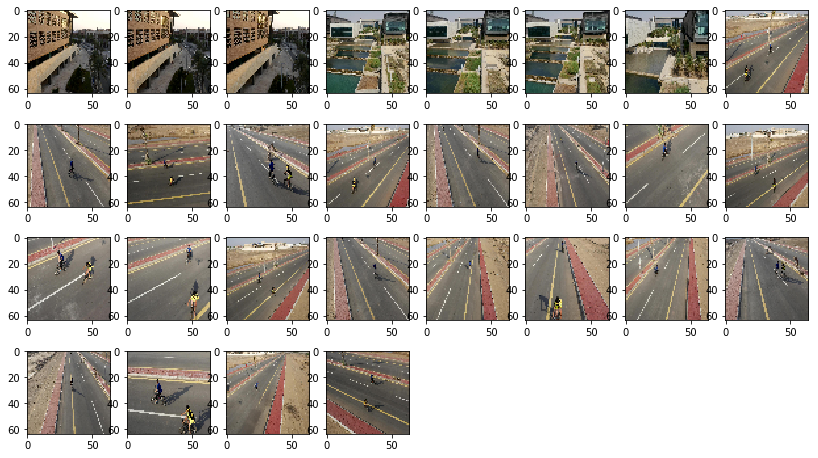

In [101]:
n = len(img_list)
print(n)
rows = 4
columns = 8
fig=plt.figure(figsize=(14, 8))

for i in range(n):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img_list[i])
plt.show()
    